In [239]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import os
dir_path = os.getcwd()


In [58]:
d_types = ['data', 'test']
data = dict()
for d_type in d_types:
        path = dir_path +"/"+"classification_data_HWK2/EMGaussian." + d_type 
        data[d_type] = pd.read_csv(path, sep=' ', header=None).values

In [59]:
print(data['data'][0:5, :])

[[ 0.91029   0.016192]
 [-2.531     6.6981  ]
 [ 4.3602    8.3541  ]
 [-0.70489  -0.51343 ]
 [-5.7383   -6.2088  ]]


In [130]:
def computeKMeans(X, niterMax):
    x0min = np.min(X[:, 0])
    x0max = np.max(X[:, 0])
    x1min = np.min(X[:, 1])
    x1max = np.max(X[:, 1])
    oldCenters = [[0,0] for i in range(4)]
    centers = np.random.rand(4,2)
    centers[:,0] = ((x0max - x0min)*centers[:,0])+x0min
    centers[:,1] = ((x1max - x1min)*centers[:,1])+x1min
    clusters = [4 for i in range(len(X))]
    i = 0
    while not np.array_equal(centers,oldCenters) and i < niterMax:
        oldCenters = np.copy(centers)
        i += 1
        for j in range(len(X)):
            minDist = 1000000000
            cluster = 4
            for k in range(len(centers)):
                dist = np.linalg.norm(X[j]-centers[k])
                if dist < minDist:
                    minDist = dist
                    cluster = k
            clusters[j]=cluster
        
        for l in range(len(centers)):
            equal = [l for i in range(len(X))]
            subset = [clusters[m]==l for m in range(len(clusters))]
            Xsubset = X[subset,:]
            if len(Xsubset) > 0:
                centers[l] = Xsubset.mean(0)
                
            
    return centers, clusters
            
        

In [131]:
def plotKMeans(X, centers, clusters):
    for l in range(len(centers)):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset,:]
        x0 = Xsubset[:, 0]
        x1 = Xsubset[:, 1]
        plt.scatter(x0, x1)
        
    plt.scatter(centers[:,0], centers[:,1])
    
    plt.title("K-means")
    plt.show()
    
    
def computeDistortionMeasures(X, centers, clusters):
    measure = 0
    for l in range(len(centers)):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset,:]
        norm = [np.linalg.norm(Xsubset[m]-centers[l]) for m in range(len(Xsubset))]
        measure += sum(norm)
        
    return measure
        
    

In [132]:
X = data['data']
centers, clusters = computeKMeans(X, 1)
computeDistortionMeasures(X, centers, clusters)

1593.3885639589437

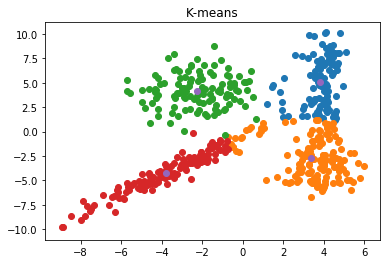

centers :
[ 3.8028082568807355 5.104672477064219 ]
[ 3.3644967202797202 -2.6564698321678315 ]
[ -2.2385622100840337 4.163396605042017 ]
[ -3.78479953488372 -4.216397131782944 ]
distortion measure :  1108.4646065085099


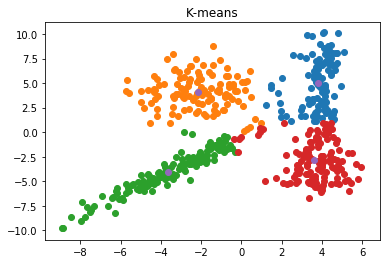

centers :
[ 3.788092857142859 4.99905357142857 ]
[ -2.155464900826446 4.112993884297521 ]
[ -3.6366213970588226 -4.05302194117647 ]
[ 3.6040187099236647 -2.8877266870229006 ]
distortion measure :  1102.5458611063004


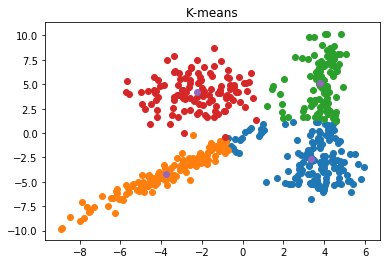

centers :
[ 3.3644967202797202 -2.6564698321678315 ]
[ -3.78479953488372 -4.216397131782944 ]
[ 3.8028082568807355 5.104672477064219 ]
[ -2.2385622100840337 4.163396605042017 ]
distortion measure :  1108.46460650851


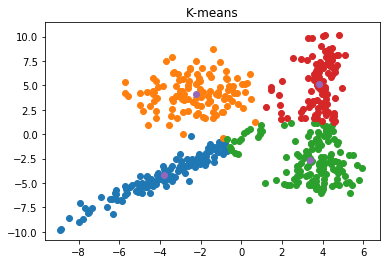

centers :
[ -3.78479953488372 -4.216397131782944 ]
[ -2.2385622100840337 4.163396605042017 ]
[ 3.3644967202797202 -2.6564698321678315 ]
[ 3.8028082568807355 5.104672477064219 ]
distortion measure :  1108.46460650851


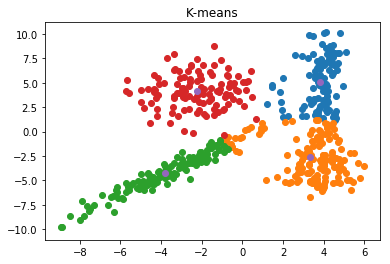

centers :
[ 3.8028082568807355 5.104672477064219 ]
[ 3.3355796597222227 -2.644529 ]
[ -3.818793543307086 -4.274234409448818 ]
[ -2.240347525 4.127447716666667 ]
distortion measure :  1109.4166282170172


In [133]:
for i in range(5):
    X = data['data']
    centers, clusters = computeKMeans(X, 1000)
    plotKMeans(X, centers, clusters)
    distortionMeasure = computeDistortionMeasures(X, centers, clusters)
    print("centers :")
    for i in range(len(centers)):
        print("[",*centers[i],"]")
    print("distortion measure : ",distortionMeasure)

### b) Gaussian Mixture with covariance matrix proportionnal to the identity

In [399]:
def computeEMForB(X, niter):
    centers, clusters = computeKMeans(100) #todo use max of 10 iterations
    
    # ----------------- init pi
    pi = [0,0,0,0]
    for l in range(4):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        pi[l]= np.sum(subset)/len(X)
    
    # ----------------- init sigmas
    sigmas = dict()
    for l in range(4):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset, :]
        sigma = (np.sum((Xsubset - centers[l])**2))/len(Xsubset)
        sigmas[l] = sigma * np.identity(2)
    
        
    # ----------------- init q
    q = np.zeros((len(X), 4))
    
    n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0]*np.identity(2))
    
    for i in range(niter):
        # E step
        n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0])
        n1 = scipy.stats.multivariate_normal(centers[1], sigmas[1])
        n2 = scipy.stats.multivariate_normal(centers[2], sigmas[2])
        n3 = scipy.stats.multivariate_normal(centers[3], sigmas[3])
        for x in range(len(X)):
            n0x = n0.pdf(X[x])
            n1x = n1.pdf(X[x])
            n2x = n2.pdf(X[x])
            n3x = n3.pdf(X[x])
            tot = n0x+n1x+n2x+n3x
            q[x,0] = n0x/tot
            q[x,1] = n1x/tot
            q[x,2] = n2x/tot
            q[x,3] = n3x/tot

        # M step
        for l in range(4):
            sumq = np.sum(q[:,l])
            pi[l] = sumq/(np.sum(q[:,0])+np.sum(q[:,1])+np.sum(q[:,2])+np.sum(q[:,3]))
            centers[l] = ([q[k,l]*X[k] for k in range(len(X))]/sumq).sum(0)

            Xcentered = [X[k]-centers[l] for k in range(len(X))]
            Xcenteredsquare = [x**2 for x in Xcentered]
            Xcenteredsquareq = [Xcenteredsquare[k]*q[k,l] for k in range(len(Xcenteredsquare))]
            sigma = 0.5*np.sum(Xcenteredsquareq)/sumq
            sigmas[l] = sigma * np.identity(2)
        
    return pi, centers, sigmas, q
            
        
        

In [400]:
# see https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
def plot_cov_ellipse(cov, pos, color, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    ellip.set_clip_box(ax.bbox)
    ellip.set_alpha(0.3)
    ellip.set_facecolor(color)
    return ellip

In [401]:
def plotEM(X, centers, sigmas, q):
    x0 = X[:, 0]
    x1 = X[:, 1]
     
    label_color_map = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   3 : 'purple'
                   }

    fig = figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
        
    ax.scatter(centers[:,0], centers[:,1], color="black", marker = 'v')
    for i in range(4):
        ell = plot_cov_ellipse(sigmas[i], centers[i, :], label_color_map[i], 1.645,ax) #1.645 is equivalenrt to 90%
        
    
    clusters = np.argmax(q,1)
    label_color = [label_color_map[l] for l in clusters]
    ax.scatter(X[:,0], X[:,1], c=label_color, marker="o", s=50)
    
    plt.title("EM with Cov Matrices % to Id Matrix")
    ax.set_xlim(-10, 10)
    ax.set_ylim(-11, 11)
    plt.show()
    

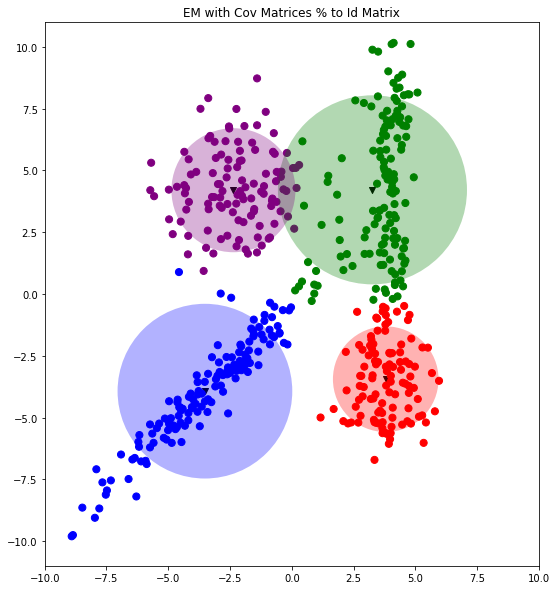

for gaussian 0
	 pi :
	 0.22053761709874722
	 center :
	 [ -2.361352947793982 4.199877540115077 ]
	 cov matrice :
	 [ 1.6879437194424318 0.0 ]
	 [ 0.0 1.6879437194424318 ]
for gaussian 1
	 pi :
	 0.26579587037154784
	 center :
	 [ -2.361352947793982 4.199877540115077 ]
	 cov matrice :
	 [ 5.410227950643357 0.0 ]
	 [ 0.0 5.410227950643357 ]
for gaussian 2
	 pi :
	 0.24667385098808786
	 center :
	 [ -2.361352947793982 4.199877540115077 ]
	 cov matrice :
	 [ 4.619014016809732 0.0 ]
	 [ 0.0 4.619014016809732 ]
for gaussian 3
	 pi :
	 0.26699266154161705
	 center :
	 [ -2.361352947793982 4.199877540115077 ]
	 cov matrice :
	 [ 2.3276047163775844 0.0 ]
	 [ 0.0 2.3276047163775844 ]


In [402]:
X = data['data']
_, centers, sigmas, q = computeEMForB(X, 100)
plotEM(X, centers, sigmas, q)
for key in sigmas:
    print("for gaussian", key)
    print("\t pi :")
    print("\t", pi[key])
    print("\t center :")
    print("\t [",*centers[i],"]")
    print("\t cov matrice :")
    print("\t [",*sigmas[key][0],"]")
    print("\t [",*sigmas[key][1],"]")

In [316]:
# from pylab import figure, show, rand
# from matplotlib.patches import Ellipse

# _, centers, sigmas, q = computeEMForB(X, 100)
# label_color_map = {0 : 'r',
#                    1 : 'g',
#                    2 : 'b',
#                    3 : 'purple'
#                    }

# ells = [Ellipse(xy=centers[i], width=2*np.sqrt(5.991*sigmas[i]), height=2*np.sqrt(5.991*sigmas[i]), angle=0)
#         for i in range(4)]

# fig = figure(figsize=(10,10))
# ax = fig.add_subplot(111, aspect='equal')
# for e,i in zip(ells,range(4)):
#     ax.add_artist(e)
#     e.set_clip_box(ax.bbox)
#     e.set_alpha(0.3)
#     e.set_facecolor(label_color_map[i])
    
    

# clusters = np.argmax(q,1)
    


# label_color = [label_color_map[l] for l in clusters]


# ax.scatter(X[:,0], X[:,1], c=label_color, marker="o", s=50)
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)

# show()


### c) Gaussian Mixture with general covariance matrix

In [403]:
def computeEMForC(X, niter):
    centers, clusters = computeKMeans(100) #todo use max of 10 iterations
    
    # ----------------- init pi
    pi = [0,0,0,0]
    for l in range(4):
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        pi[l]= np.sum(subset)/len(X)
    
    # ----------------- init cov matrices
    sigmas = dict()
    for l in range(4):
        sigmas[l] = np.zeros((2,2))
        equal = [l for i in range(len(X))]
        subset = [clusters[m]==l for m in range(len(clusters))]
        Xsubset = X[subset, :]
        var = (((Xsubset - centers[l])**2)/len(Xsubset)).sum(0)
        sigmas[l][0,0] = var[0]
        sigmas[l][1,1] = var[1]
        
    # ----------------- init q
    q = np.zeros((len(X), 4))
    
    n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0]*np.identity(2))
    
    for i in range(niter):
        # E step
        n0 = scipy.stats.multivariate_normal(centers[0], sigmas[0])
        n1 = scipy.stats.multivariate_normal(centers[1], sigmas[1])
        n2 = scipy.stats.multivariate_normal(centers[2], sigmas[2])
        n3 = scipy.stats.multivariate_normal(centers[3], sigmas[3])
        for x in range(len(X)):
            n0x = n0.pdf(X[x])
            n1x = n1.pdf(X[x])
            n2x = n2.pdf(X[x])
            n3x = n3.pdf(X[x])
            tot = n0x+n1x+n2x+n3x
            q[x,0] = n0x/tot
            q[x,1] = n1x/tot
            q[x,2] = n2x/tot
            q[x,3] = n3x/tot

        # M step
        for l in range(4):
            sumq = np.sum(q[:,l])
            pi[l] = sumq/(np.sum(q[:,0])+np.sum(q[:,1])+np.sum(q[:,2])+np.sum(q[:,3]))
            centers[l] = ([q[k,l]*X[k] for k in range(len(X))]/sumq).sum(0)

            Xcentered = [X[k]-centers[l] for k in range(len(X))]
            tmpSigma = np.zeros((2,2))
            for k in range(len(Xcentered)):
                tmpX = np.dot(Xcentered[k].reshape(2,1), Xcentered[k].reshape(1,2))
                tmpX = tmpX * q[k,l]
                tmpSigma += tmpX
            tmpSigma = tmpSigma / sumq
            sigmas[l] = tmpSigma
        
    return pi, centers, sigmas, q
            
        
            

In [404]:
# def plotEMForC(X, centers, sigmas, q):
#     x0 = X[:, 0]
#     x1 = X[:, 1]
     
#     label_color_map = {0 : 'r',
#                    1 : 'g',
#                    2 : 'b',
#                    3 : 'purple'
#                    }

#     fig = figure(figsize=(10,10))
#     ax = fig.add_subplot(111, aspect='equal')
        
#     ax.scatter(centers[:,0], centers[:,1], color="black", marker = 'v')
#     for i in range(4):
#         ell = plot_cov_ellipse(sigmas[i], centers[i, :], label_color_map[i], 1.645,ax) #1.645 is equivalenrt to 90%
        
    
#     clusters = np.argmax(q,1)
#     label_color = [label_color_map[l] for l in clusters]
#     ax.scatter(X[:,0], X[:,1], c=label_color, marker="o", s=50)
    
#     plt.title("EM with general Cov Matrices")
#     ax.set_xlim(-10, 10)
#     ax.set_ylim(-11, 11)
#     plt.show()

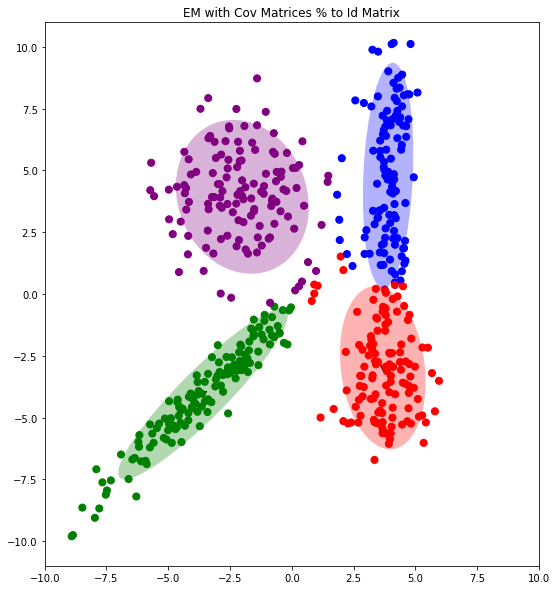

for gaussian 0
	 pi :
	 0.24512331436126814
	 center :
	 [ -2.001494132334413 3.9334013920220134 ]
	 cov matrice :
	 [ 1.1093199450051812 -0.366732854771571 ]
	 [ -0.366732854771571 4.027189988257856 ]
for gaussian 1
	 pi :
	 0.2726157045710061
	 center :
	 [ -2.001494132334413 3.9334013920220134 ]
	 cov matrice :
	 [ 4.3469787464066885 4.029146652007568 ]
	 [ 4.029146652007568 4.394722140654413 ]
for gaussian 2
	 pi :
	 0.22460680385403267
	 center :
	 [ -2.001494132334413 3.9334013920220134 ]
	 cov matrice :
	 [ 0.3841300714268141 0.31962375540926946 ]
	 [ 0.31962375540926946 7.691620228514115 ]
for gaussian 3
	 pi :
	 0.25765417721369305
	 center :
	 [ -2.001494132334413 3.9334013920220134 ]
	 cov matrice :
	 [ 2.6733525487880314 -0.4133164456428144 ]
	 [ -0.4133164456428144 3.580608434871229 ]


In [405]:
X = data['data']
pi, centers, sigmas, q = computeEMForC(X, 1)
plotEM(X, centers, sigmas, q)
for key in sigmas:
    print("for gaussian", key)
    print("\t pi :")
    print("\t", pi[key])
    print("\t center :")
    print("\t [",*centers[i],"]")
    print("\t cov matrice :")
    print("\t [",*sigmas[key][0],"]")
    print("\t [",*sigmas[key][1],"]")